In [1]:
import sys
sys.path.append('../scripts/')
from kld_mcl import *

In [2]:
class GlobalKldMcl(KldMcl):  
    def __init__(self, envmap, max_num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2},
                 distance_dev_rate=0.14, direction_dev=0.05): #姿勢の引数を消す
        super().__init__(envmap, np.array([0, 0, 0]).T, max_num, motion_noise_stds, distance_dev_rate, direction_dev) #初期姿勢は適当に
        self.particles = [Particle(None, 1.0/max_num) for i in range(max_num)] #パーティクル作り直し
        for p in self.particles: #ランダムに姿勢を初期化し直す
            p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T

        self.observed = False #観測のあるときはTrueにして無駄なKLDサンプリングを無くす
        
    def motion_update(self, nu, omega, time):  
        if not self.observed and len(self.particles) == self.max_num: #観測がなくパーティクル数が上限なら単にパーティクルを動かして終わり．パーティクルを増やさない
            for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            return
        
        super().motion_update(nu, omega, time)

    def observation_update(self, observation):   
        super().observation_update(observation)
        self.observed = len(observation) > 0             #観測があったかどうかを記録

In [3]:
def trial(animation): 
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = GlobalKldMcl(m, 10000)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

<IPython.core.display.Javascript object>


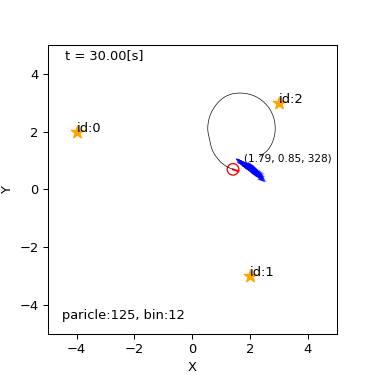

(array([2.32730241, 1.13929726, 0.50329519]), array([0, 0, 0]))

In [6]:
trial(True)